In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

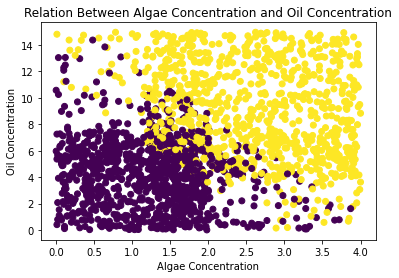

Accuracy = 80.88004190675746%


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

# 1. Load Data
train = spark.read.csv("Training.csv", inferSchema=True, header=True)
test = spark.read.csv("Testing.csv", inferSchema=True, header=True)

# 2. Select Feature
train = train.select("Trash Pollution", "Oil Concentration", "Algae Concentration")
test = test.select("Trash Pollution", "Oil Concentration", "Algae Concentration", "Polluted")

# 3. Data Preprocessing
train = train.na.drop()
test = test.na.drop()

# 4. Transform Data
train = train.withColumn("Trash Pollution", when(train["Trash Pollution"] == "Low", 0).when(train["Trash Pollution"] == "Medium", 1).otherwise(2))

test = test.withColumn("Trash Pollution", when(test["Trash Pollution"] == "Low", 0).when(test["Trash Pollution"] == "Medium", 1).otherwise(2))
test = test.withColumn("Polluted",when(test["Polluted"] == "No", 0).otherwise(1))

# 5. Normalization
columns = train.columns
columns = test.columns
columns.remove("Polluted")

train = VectorAssembler(inputCols=columns, outputCol="FeatureVector").transform(train)
test = VectorAssembler(inputCols=columns, outputCol="FeatureVector").transform(test)

train = StandardScaler(inputCol="FeatureVector", outputCol="Feature").fit(train).transform(train)
test = StandardScaler(inputCol="FeatureVector", outputCol="Feature").fit(test).transform(test)

# 6. Generate Model
kmeans = KMeans(featuresCol="Feature",k=2, seed=1)
model = kmeans.fit(train)
predict = model.transform(test)
pandas = predict.toPandas()

# 7. Visualization 
plt.scatter(pandas["Oil Concentration"],pandas["Algae Concentration"], c= pandas["prediction"])
plt.title("Relation Between Algae Concentration and Oil Concentration")
plt.xlabel("Algae Concentration")
plt.ylabel("Oil Concentration")
plt.show()

# 8. Model Testing and Evaluation
counter = 0
for index, row in pandas.iterrows():
  if row["Polluted"] == row["prediction"]:
    counter +=1
print(f"Accuracy = {((counter/predict.count()) * 100)}%")